# Expression boxplots with bicistronic transcripts
- "Bicistronic": Using a subset of Skeletal muscle samples, RNA-Seq reads were remapped to bicistronic transcripts (ATP8/ATP6 and ND4L/ND4) by modifying the GTEx Docker pipeline (https://github.com/broadinstitute/gtex-pipeline/tree/master/rnaseq).
- "Original": Replicating the GTEx gene read counts for these samples, without modifying the transcript information.

In [1]:
import pandas as pd
#pd.set_option("display.max_rows", None, "display.max_columns", None)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import statistics
import statsmodels.api as sm
from itertools import permutations
#import pdfkit as pdf

import seaborn as sns; sns.set(style="ticks", color_codes=True)

from Bio import SeqIO
import sys

import os
import glob

In [91]:
# Lists of genes (exclude ND5 and ND6).
list_mt_original = ['MT-ATP8','MT-ATP6','MT-ND4L','MT-ND4','MT-ND1','MT-ND2','MT-ND3','MT-CO1','MT-CO2','MT-CO3','MT-CYB']
list_mt_bicistronic = ['MT-ATP8_MT-ATP6','MT-ND4L_MT-ND4','MT-ND1','MT-ND2','MT-ND3','MT-CO1','MT-CO2','MT-CO3','MT-CYB']

list_original = ['ATP8','ATP6','ND4L','ND4','ND1','ND2','ND3','CO1','CO2','CO3','CYB']
list_bicistronic = ['ATP8/6','ND4L/4','ND1','ND2','ND3','CO1','CO2','CO3','CYB']

In [3]:
# Dictionary containing alternate names for genes (without prefix 'MT-').
dict_gene_names = {
    'MT-ATP8_MT-ATP6':'ATP8/ATP6' , 'MT-ND4L_MT-ND4':'ND4L/ND4' , 'MT-ND1':'ND1' , 'MT-ND2':'ND2' , 'MT-ND3':'ND3' ,
    'MT-ND4':'ND4', 'MT-ND4L':'ND4L' , 'MT-ND5':'ND5' , 'MT-ND6':'ND6' , 'MT-CO1':'CO1' , 'MT-CO2':'CO2' , 
    'MT-CO3':'CO3' , 'MT-CYB':'CYB' , 'MT-ATP8':'ATP8' , 'MT-ATP6':'ATP6'
}

## After generating gene read counts per sample (modified GTEx RNA-Seq analysis Docker pipeline), combine them into a single file.

In [ ]:
# Import the SRR IDs for the 'Original' directory.
ids_orig = pd.read_table("../data/transfer.2022-05-05/docker_out/ids.original.txt", header=None)
# Turn into a list.
ids_orig = ids_orig[0].tolist()

In [7]:
def join_tpm(version):
   
    # Use glob to get all the TPM (.gct) files in the directory
    # in the folder
    path = "../data/transfer.2022-05-05/docker_out/"+version
    csv_files = glob.glob(os.path.join(path, "*.gct"))
    
    for SRR in ids_orig:
        # Get the file name for this SRR.
        for DIR in csv_files:
            if DIR.find(SRR)!= -1:
                dir_file = DIR                
        # Import the TPM file.
        df_in = pd.read_table( dir_file , skiprows=2 )
        # Change name of TPM column to the SRR id.
        df_in.columns = df_in.columns.str.replace('TPM', SRR)
        # The first SRR becomes the df that will be used to merge.
        if SRR == ids_orig[0]:
            df_out = df_in
        if SRR != ids_orig[0]:
            df_out = pd.merge(df_out,df_in)
    return df_out


df_original = join_tpm("original")
df_bicistronic = join_tpm("bicistronic")

### Export the multi-sample TPM files.

In [46]:
#df_original.to_csv("../results/docker.original.2022-05-05.gct")

In [47]:
#df_bicistronic.to_csv("../results/docker.bicistronic.2022-05-05.gct")

## Get the SRR ID to GTEx ID information (from SRA Run Selector metadata).

In [ ]:
df_id = pd.read_csv("../data/RunSelector_MetaData_GTEx.txt")
# Select SRR and short GTEx ID columns.
df_id = df_id[["Run","submitted_subject_id","biospecimen_repository_sample_id"]]
# Change column names.
df_id.columns = ['SRR_ID','short_ID',"GTEX_ID"]

## Get the info (Population, mtdna haplogroup, Tissue).

In [ ]:
df_info = pd.read_table("../data/secure/phenotypes_v8.txt")
# Change column names.
df_info.columns = ['GTEX_ID','short_ID','Population','mtDNA_haplo','Tissue']
# Change 2 to AfAm, and 3 to EuAm.
df_info['Population'] = [ {3:'EuAm',2:'AfAm'}[row] for row in df_info['Population'] ]

## Keep only mtDNA genes, wrangle, and add annotations.

In [63]:
def keep_mtdna(df):
    # Keep only genes that start with 'MT-'.
    return df[df['Description'].str.contains("MT-")]

def melt_SRR(df):
    df_mt = keep_mtdna(df)
    # Melt TPM columns to form SRR column.
    # List of SRR columns.
    #return list(df_mt.columns)[2:]
    df_melt = df_mt.melt(id_vars='Description',
                value_vars=list(df_mt.columns)[2:] ,
                #value_vars=['MT-ND1','MT-ND2','MT-CO1','MT-CO2','MT-CO3','MT-ND3','MT-CYB','MT-ND5','MT-ND6'],
                var_name=['SRR_ID'], value_name='TPM')
    return df_melt

def add_gtexid(df):
    df_melt = melt_SRR(df)
    # Merge short GTEX ID using SRR column.
    return pd.merge(df_id,df_melt)

def add_info(df):
    df_melt_id = add_gtexid(df)
    # Change name of 'Description' column to 'Gene'.
    df_melt_id.columns = df_melt_id.columns.str.replace('Description','Gene')
    # Annotate with race, mtdna haplogroup, tissue.
    df_melt_id_info = pd.merge(df_melt_id,df_info)
    # Drop non-Skeletal Muscle samples (e.g. Testis).
    return df_melt_id_info[df_melt_id_info['Tissue']=='Muscle - Skeletal']


#keep_mtdna(df_original)
#melt_SRR(df_original)
#add_gtexid(df_original)
df_original_info = add_info(df_original)#['Tissue'].value_counts()
df_bicistronic_info = add_info(df_bicistronic)

In [65]:
# Sample size (skeletal muscle).
df_bicistronic_info[['short_ID','Population']].drop_duplicates()['Population'].value_counts()

EuAm    102
AfAm     55
Name: Population, dtype: int64

### Export the multi-sample TPM files (with annotations).

In [68]:
#df_original_info.to_csv("../results/docker.original.2022-05-18.annot.txt")

In [69]:
#df_bicistronic_info.to_csv("../results/docker.bicistronic.2022-05-18.annot.txt")

# Plot expression by population.

In [70]:
def boxplot_genes(df):
    # Change mtdna gene names.
    df['Gene'] = [ dict_gene_names[gene] for gene in df['Gene'] ]
    # Change population names.
    df['Population'] = [ {'AfAm':'African Americans','EuAm':'European Americans'}[x] for x in df['Population'] ]
    # Size of plot and text.
    sns.set(rc={'figure.figsize':(30,15)},font_scale=2.5)
    # Style of plot.
    sns.set_style("ticks")
    # Create boxplot.
    sns.boxplot(data=df.sort_values(['Gene']) ,
               x='Gene' ,
               y='TPM',
               hue='Population',
               hue_order=['African Americans','European Americans'],
               palette="Blues_r"
               )
    plt.xlabel('\nGene')
    plt.ylabel('Normalized gene expression (TPM)')
    plt.xticks(rotation=0, fontstyle='italic')
    plt.legend()
    
#boxplot_genes( df_original_info[df_original_info['Gene'].isin(['MT-ND4','MT-ND4L','MT-ATP8','MT-ATP6'])] )

/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


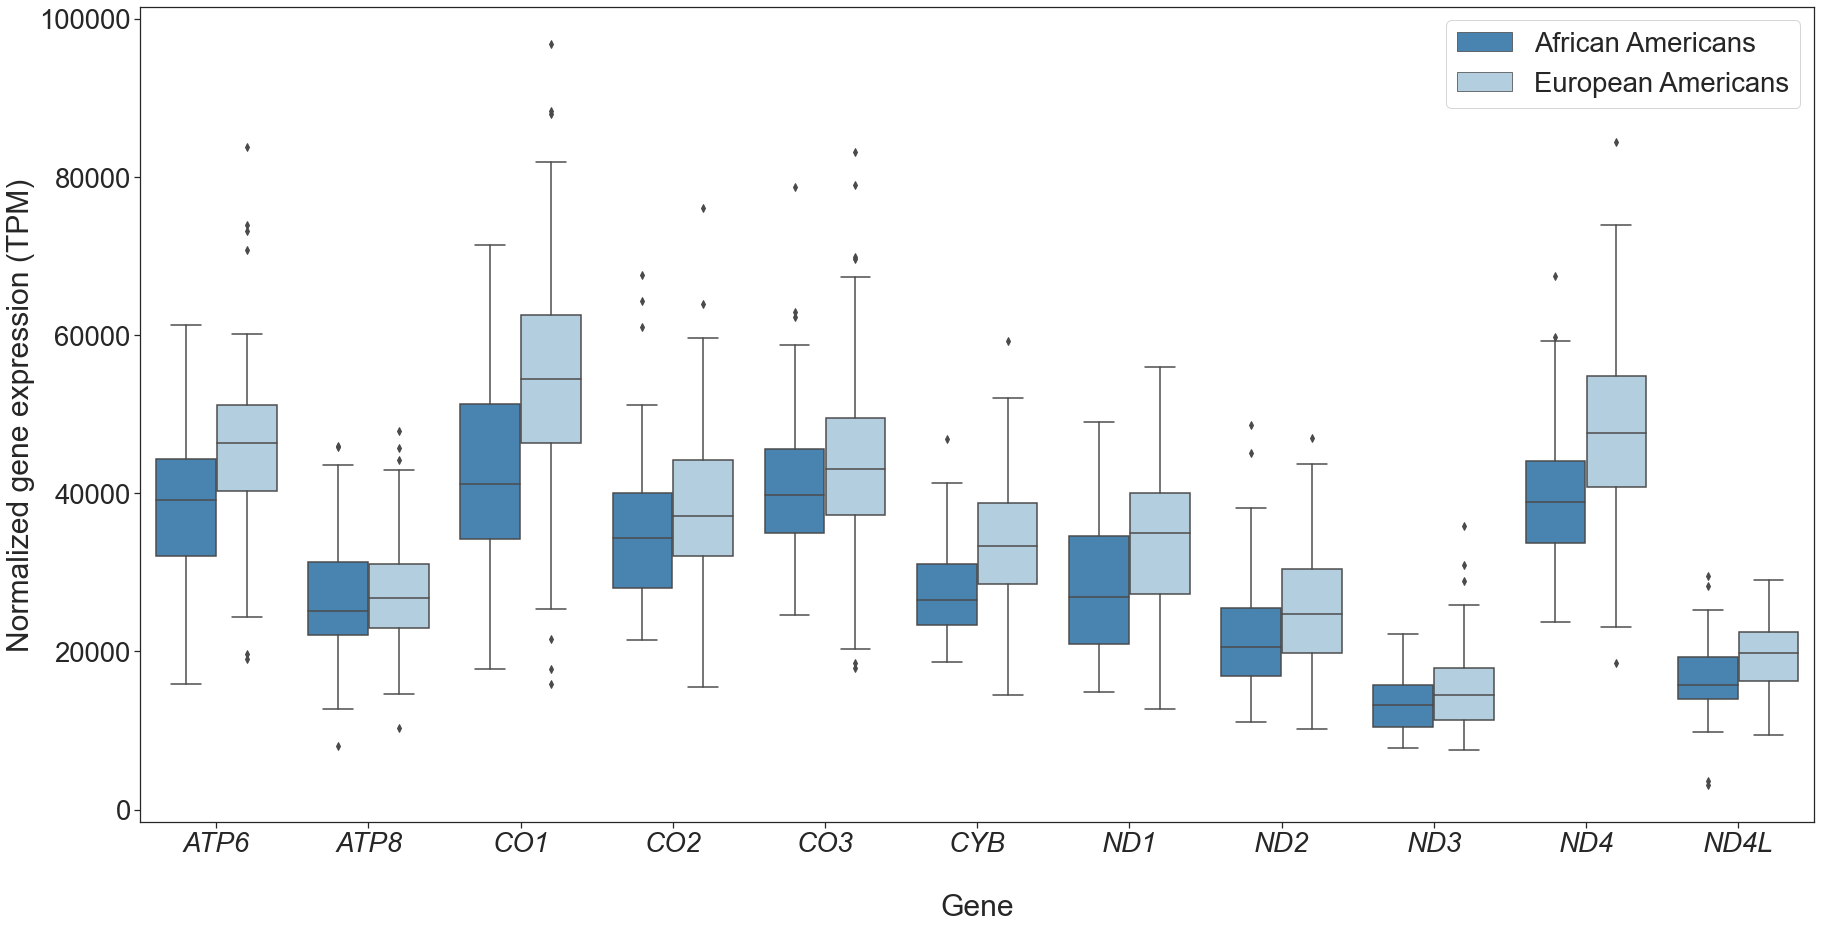

In [71]:
# Replicating the original GTEx results (ATP8, ATP6, ND4L, and ND4 treated separately).
boxplot_genes( df_original_info[df_original_info['Gene'].isin(list_mt_original)] )

/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


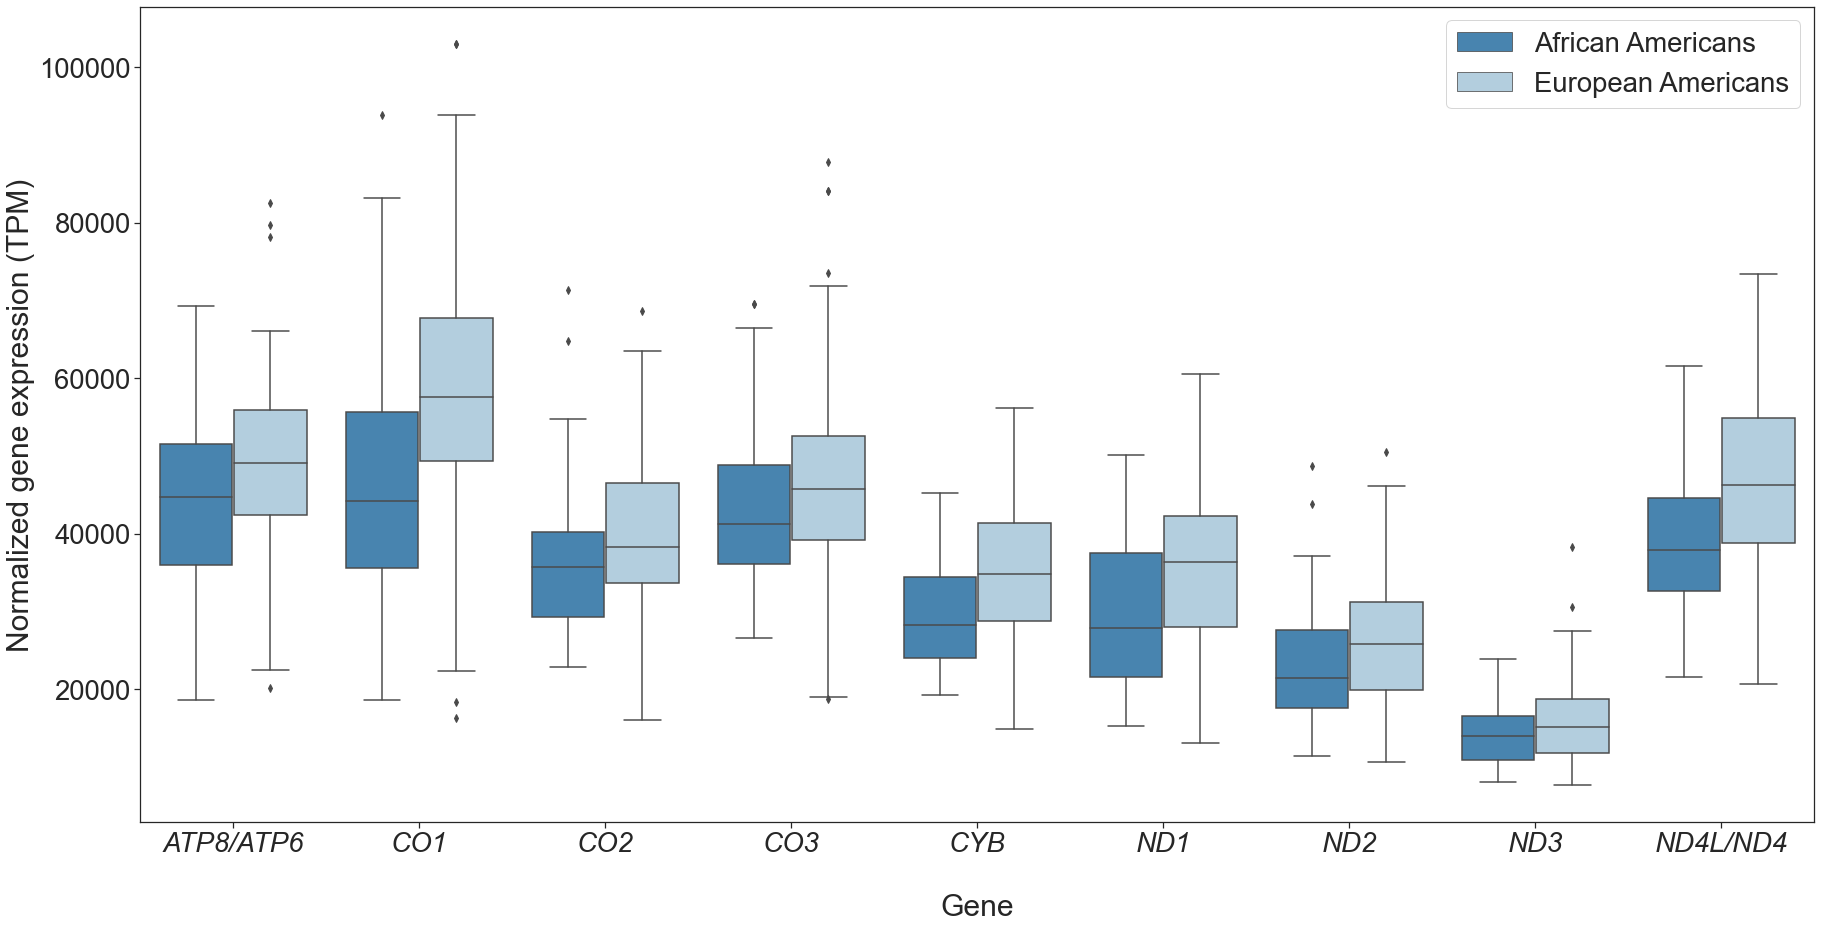

In [72]:
# Expression boxplots with bicistronic mtDNA transcripts (ATP8/ATP6 and ND4L/ND4).
boxplot_genes( df_bicistronic_info[df_bicistronic_info['Gene'].isin(list_mt_bicistronic)] )

## Two sample t-test.

In [73]:
# This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. 
# This test assumes that the populations have identical variances by default.
## Apparently no minimum sample size, but power is severely limited.

def ttest_test(df,gene):
    data = df[df['Gene']==gene]
    data_euam = data[data['Population']=='EuAm']
    data_afam = data[data['Population']=='AfAm']
    #return(data_euam)
    results = stats.ttest_ind( data_euam['TPM'] , data_afam['TPM'] , alternative='greater')
    return(results)

# Get MWU results for a list of genes.
def table_ttest_test(df,list_genes):
    # Empty table.
    table = pd.DataFrame({'Gene':[],'Statistic':[],'P-value':[]})
    for gene in list_genes:
        # Get statistic and p-value from t-test.
        results = ttest_test(df,gene)
        # Put into pd df format.
        new_row = pd.DataFrame({'Gene':[gene],'Statistic':[results.statistic],'P-value':[results.pvalue]})
        # Concatenate at end of table.
        table = pd.concat([table, new_row ])
    # Bonferroni correction by number of transcripts.
    table['Bonferroni P-value'] = table['P-value']*len(list_genes)
    # Change mtdna gene names.
    table['Gene'] = [ dict_gene_names[gene] for gene in table['Gene'] ]
    return table

In [74]:
table_ttest_test(df_original_info,list_mt_original)

,Gene,Statistic,P-value,Bonferroni P-value
0,ATP8,0.593213,2.769407e-01,3.046348
0,ATP6,4.501089,6.502068e-06,0.000072
0,ND4L,4.296127,1.508207e-05,0.000166
0,ND4,4.516005,6.109361e-06,0.000067
0,ND1,4.326404,1.334247e-05,0.000147
0,ND2,2.870545,2.327915e-03,0.025607
0,ND3,2.895189,2.161253e-03,0.023774
0,CO1,4.968084,8.654667e-07,0.000010
0,CO2,1.400948,8.158913e-02,0.897480
0,CO3,1.469570,7.182714e-02,0.790098


In [75]:
table_ttest_test(df_bicistronic_info,list_mt_bicistronic)

,Gene,Statistic,P-value,Bonferroni P-value
0,ATP8/ATP6,3.300667,0.000595,0.005359
0,ND4L/ND4,4.194971,0.000023,0.000204
0,ND1,4.133442,0.000029,0.000260
0,ND2,2.661034,0.004295,0.038652
0,ND3,3.038051,0.001392,0.012529
0,CO1,3.911105,0.000068,0.000611
0,CO2,1.551568,0.061377,0.552392
0,CO3,1.510046,0.066508,0.598574
0,CYB,4.119455,0.000030,0.000274


## Mann Whitney U test.

In [76]:
### Make table of the 'genes' compared across EuAm vs. AfAm, and 'p-values' of two-sided Mann-Whitney U test.
# Use only when the number of observation in each sample is > 20 and you have 2 independent samples of ranks. 
# Mann-Whitney U is significant if the u-obtained is LESS THAN or equal to the critical value of U.

# MWU results for a single gene.
def mwu_test(df,gene):
    # Filter for a single genes.
    data = df[df['Gene']==gene]
    # Split by population.
    data_euam = data[data['Population']=='EuAm']
    data_afam = data[data['Population']=='AfAm']
    # Returns statistic and p-value for a MWU test.
    results = stats.mannwhitneyu( data_euam['TPM'] , data_afam['TPM'] , alternative='greater')
    return(results)

# Get MWU results for a list of genes.
def table_mwu_test(df,list_genes):
    # Empty table.
    table = pd.DataFrame({'Gene':[],'Statistic':[],'P-value':[]})
    for gene in list_genes:
        # Get statistic and p-value from MWU test.
        results = mwu_test(df,gene)
        # Put into pd df format.
        new_row = pd.DataFrame({'Gene':[gene],'Statistic':[results.statistic],'P-value':[results.pvalue]})
        # Concatenate at end of table.
        table = pd.concat([table, new_row ])
    # Bonferroni correction by number of transcripts.
    table['Bonferroni P-value'] = table['P-value']*len(list_genes)
    # Change mtdna gene names.
    table['Gene'] = [ dict_gene_names[gene] for gene in table['Gene'] ]
    return table
    

#mwu_test(df_original_info,'MT-ND4L')
#mwu_test(df_bicistronic_info,'MT-ND4L_MT-ND4')
#table_mwu_test(df_original_info,list_mt_original)

In [77]:
table_mwu_test(df_original_info,list_mt_original)

,Gene,Statistic,P-value,Bonferroni P-value
0,ATP8,3106.0,2.485570e-01,2.734127
0,ATP6,4178.0,3.394741e-06,0.000037
0,ND4L,4084.0,1.555942e-05,0.000171
0,ND4,4206.0,2.112560e-06,0.000023
0,ND1,4084.0,1.555942e-05,0.000171
0,ND2,3836.0,5.169716e-04,0.005687
0,ND3,3682.0,3.145736e-03,0.034603
0,CO1,4296.0,4.309675e-07,0.000005
0,CO2,3488.0,2.064146e-02,0.227056
0,CO3,3481.0,2.191433e-02,0.241058


In [78]:
table_mwu_test(df_bicistronic_info,list_mt_bicistronic)

,Gene,Statistic,P-value,Bonferroni P-value
0,ATP8/ATP6,3837.5,0.000507,0.004564
0,ND4L/ND4,4054.5,0.000025,0.000221
0,ND1,4018.5,0.000042,0.000379
0,ND2,3736.5,0.001714,0.015424
0,ND3,3691.5,0.002836,0.025526
0,CO1,4076.5,0.000017,0.000157
0,CO2,3522.5,0.015243,0.137187
0,CO3,3452.5,0.027798,0.250178
0,CYB,4054.5,0.000025,0.000221
